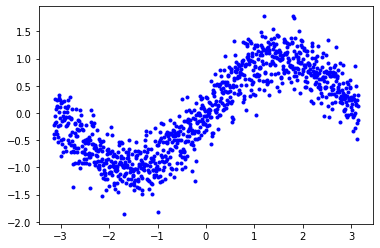

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

data = pd.read_csv('HW_data.csv')
data.head()
# plot the data
plt.scatter(data['x'], data['y'], marker='.', color='blue')

In [3]:
all_Xs = data.iloc[:, 0:1].values
all_Ys = data.iloc[:, 1:2].values

print(all_Xs.shape)
print(all_Ys.shape)

(1000, 1)
(1000, 1)


In [4]:
def split_train_test(data, ratio=0.2):
    shuffled_index = np.random.permutation(len(data))
    test_set_size = int(len(data) * ratio)
    test_index = shuffled_index[:test_set_size]
    train_index = shuffled_index[test_set_size:]
    return data.iloc[train_index], data.iloc[test_index]

In [5]:
data_for_train, data_for_test = split_train_test(data)

In [6]:
x_train = data_for_train.iloc[:, 0:1].values
x_test = data_for_test.iloc[:, 0:1].values
y_train = data_for_train.iloc[:, 1:2].values
y_test = data_for_test.iloc[:, 1:2].values

# print the x_train and y_train and x_test and y_test
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 1)
(200, 1)
(800, 1)
(200, 1)


,x,y
443,-0.355355,-0.299263
789,1.820803,0.682463
122,-2.374277,0.053289
930,2.707619,0.638035
739,1.506329,0.995488
...,...,...
474,-0.160382,-0.323378
867,2.311382,1.229174
747,1.556645,0.643045
411,-0.556619,-0.498503


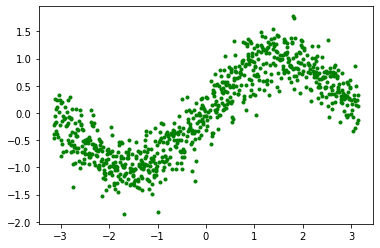

In [7]:
# plot the data_for_train
plt.scatter(x_train, y_train, marker='.', color='green')
data_for_train

,x,y
852,2.217040,0.183196
813,1.971750,0.936284
377,-0.770461,-0.374613
988,3.072408,-0.009341
610,0.694987,0.375264
...,...,...
14,-3.053540,-0.231503
140,-2.261066,-0.892312
404,-0.600645,-0.390461
387,-0.707566,-0.677441


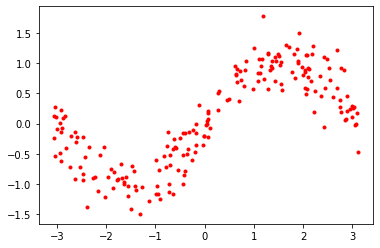

In [8]:
#plot the data_for_test
plt.scatter(x_test, y_test, marker='.', color='red')
data_for_test

In [9]:
# our way
def poly(x, degree):
    n, m = x.shape
    #? extract dimensions of the x with x.shape
    res = np.empty((n, m * degree + 1))
    #? we create an empty matrix
    # with n rows and m * degree + 1(+1 is for x0) columns
    res[:, 0] = np.ones(n)
    # every row in column 0 is 1
    for i in range(1, degree + 1):
        # we specify start and end points (for power ^)
        for j in range(m):
            # so we apply the power for all features
            res[:, (i - 1) * m + j + 1] = np.power(x[:, j], i)
            # all rows column j powered to i
    return res

In [10]:
x_poly1 = poly(all_Xs, 1)
x_poly2 = poly(all_Xs, 2)
x_poly3 = poly(all_Xs, 3)
y_std = (all_Ys - all_Ys.min()) / (all_Ys.max() - all_Ys.min())
# print(data_for_test.shape)
# print the x_poly1 and y_std
print(x_poly1.shape)
print(y_std.shape)


(1000, 2)
(1000, 1)


In [11]:
#? this is GD.py by one differance
def gradient_descent(x, y, epochs, alpha, eps=0.001):
    w = np.random.randn(x.shape[1], 1)
    epoch = 1
    loss_history = []
    while True:
        y_hat = np.dot(x, w)  # Xw ==> X@w
        error = y_hat - y
        loss = (1.0 / x.shape[0]) * error.T @ error  # MSE(loss) => 1/(n)*(y_hat-y).T@(y_hat-y)
        loss_history.append(loss[0][0])
        w -= 2 * alpha * x.T @ error  # w -= alpha*X.T(Xw-y)
        if epoch % 10000 == 0:
            print(f'Epoch [{epoch}/{epochs}]: loss = {loss}')
        if epoch > epochs or loss_history[-1] < eps:
            break
        epoch += 1
    return w, loss_history

Epoch [10000/70000]: loss = [[0.05622379]]
Epoch [20000/70000]: loss = [[0.02202892]]
Epoch [30000/70000]: loss = [[0.02140297]]
Epoch [40000/70000]: loss = [[0.02139151]]
Epoch [50000/70000]: loss = [[0.0213913]]
Epoch [60000/70000]: loss = [[0.02139129]]
Epoch [70000/70000]: loss = [[0.02139129]]


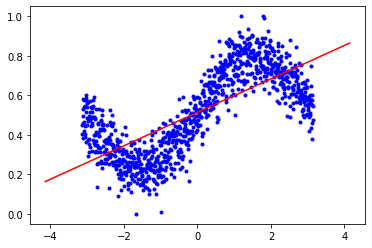

In [12]:
w_poly1, losses_poly1 = gradient_descent(x_poly1, y_std, 70000, 0.0000001)
xx = np.linspace(all_Xs.min() - 1, all_Xs.max() + 1, 100).reshape(-1, 1)
xx_poly = poly(xx, 1)
yy = np.dot(xx_poly, w_poly1)
plt.scatter(all_Xs, y_std, color='blue', marker=".")
plt.plot(xx, yy, color='red')

In [13]:
# cross validation
def cross_validate(x, y, epochs, alpha, k=5):
    n = x.shape[0]
    n_fold = int(n / k)
    loss_history = []
    for i in range(k):
        local_x_train = np.concatenate((x[:i * n_fold], x[(i + 1) * n_fold:]), axis=0)
        local_y_train = np.concatenate((y[:i * n_fold], y[(i + 1) * n_fold:]), axis=0)
        local_x_test = x[i * n_fold:(i + 1) * n_fold]
        local_y_test = y[i * n_fold:(i + 1) * n_fold]
        w, losses = gradient_descent(local_x_train, local_y_train, epochs, alpha, True)
        y_hat = np.dot(local_x_test, w)
        error = y_hat - local_y_test
        error_mse = (1.0 / local_x_test.shape[0]) * error.T @ error
        print(f'MSE: {error_mse}')
        loss_history.append(error_mse)
    return loss_history

In [14]:
loss_history_for_poly1 = cross_validate(x_poly1, y_std, 100000, 0.0000001)


MSE: [[4.5194347]]
MSE: [[0.16015238]]
MSE: [[0.17266478]]
MSE: [[1.23172206]]
MSE: [[4.25603938]]


Epoch [10000/160000]: loss = [[0.03918033]]
Epoch [20000/160000]: loss = [[0.0245494]]
Epoch [30000/160000]: loss = [[0.02195111]]
Epoch [40000/160000]: loss = [[0.0214894]]
Epoch [50000/160000]: loss = [[0.02140736]]
Epoch [60000/160000]: loss = [[0.02139278]]
Epoch [70000/160000]: loss = [[0.02139019]]
Epoch [80000/160000]: loss = [[0.02138973]]
Epoch [90000/160000]: loss = [[0.02138964]]
Epoch [100000/160000]: loss = [[0.02138963]]
Epoch [110000/160000]: loss = [[0.02138963]]
Epoch [120000/160000]: loss = [[0.02138963]]
Epoch [130000/160000]: loss = [[0.02138963]]
Epoch [140000/160000]: loss = [[0.02138963]]
Epoch [150000/160000]: loss = [[0.02138963]]
Epoch [160000/160000]: loss = [[0.02138963]]
(100, 3) (3, 1)


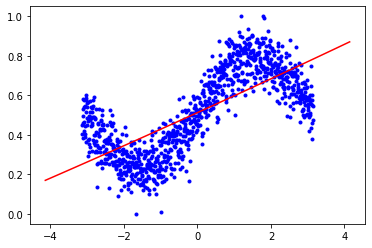

In [35]:
w_poly2, losses_poly2 = gradient_descent(x_poly2, y_std, 160000, 0.0000001)
xx = np.linspace(all_Xs.min() - 1, all_Xs.max() + 1, 100).reshape(-1, 1)
xx_poly = poly(xx, 2)
yy = np.dot(xx_poly, w_poly2)
plt.scatter(all_Xs, y_std, color='blue', marker=".")
plt.plot(xx, yy, color='red')

In [16]:
loss_history_for_poly2 = cross_validate(x_poly2, y_std, 160000, 0.0000001)

MSE: [[4.05375701]]
MSE: [[1.52474111]]
MSE: [[1.01317156]]
MSE: [[1.17001047]]
MSE: [[0.08167957]]


Epoch [10000/170000]: loss = [[0.13018642]]
Epoch [20000/170000]: loss = [[0.02476416]]
Epoch [30000/170000]: loss = [[0.00955311]]
Epoch [40000/170000]: loss = [[0.00729539]]
Epoch [50000/170000]: loss = [[0.00695049]]
Epoch [60000/170000]: loss = [[0.00689631]]
Epoch [70000/170000]: loss = [[0.00688759]]
Epoch [80000/170000]: loss = [[0.00688615]]
Epoch [90000/170000]: loss = [[0.00688591]]
Epoch [100000/170000]: loss = [[0.00688587]]
Epoch [110000/170000]: loss = [[0.00688586]]
Epoch [120000/170000]: loss = [[0.00688586]]
Epoch [130000/170000]: loss = [[0.00688586]]
Epoch [140000/170000]: loss = [[0.00688586]]
Epoch [150000/170000]: loss = [[0.00688586]]
Epoch [160000/170000]: loss = [[0.00688586]]
Epoch [170000/170000]: loss = [[0.00688586]]
(100, 4) (4, 1)


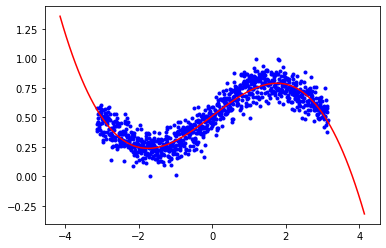

In [36]:
w_poly3, losses_poly3 = gradient_descent(x_poly3, y_std, 170000, 0.0000001)
xx = np.linspace(all_Xs.min() - 1, all_Xs.max() + 1, 100).reshape(-1, 1)
xx_poly = poly(xx, 3)
yy = np.dot(xx_poly, w_poly3)
plt.scatter(all_Xs, y_std, color='blue', marker=".")
plt.plot(xx, yy, color='red')


In [18]:
loss_history_for_poly3 = cross_validate(x_poly3, y_std, 170000, 0.0000001)


MSE: [[1.53205946]]
MSE: [[3.1454213]]
MSE: [[0.06525154]]
MSE: [[3.54711441]]
MSE: [[44.69425693]]


Epoch [10000/150000]: loss = [[0.04123588]]
Epoch [20000/150000]: loss = [[0.02647157]]
Epoch [30000/150000]: loss = [[0.02224191]]
Epoch [40000/150000]: loss = [[0.02181707]]
Epoch [50000/150000]: loss = [[0.02186394]]
Epoch [60000/150000]: loss = [[0.02190264]]
Epoch [70000/150000]: loss = [[0.02191782]]
Epoch [80000/150000]: loss = [[0.02192302]]
Epoch [90000/150000]: loss = [[0.02192474]]
Epoch [100000/150000]: loss = [[0.0219253]]
Epoch [110000/150000]: loss = [[0.02192549]]
Epoch [120000/150000]: loss = [[0.02192555]]
Epoch [130000/150000]: loss = [[0.02192556]]
Epoch [140000/150000]: loss = [[0.02192557]]
Epoch [150000/150000]: loss = [[0.02192557]]


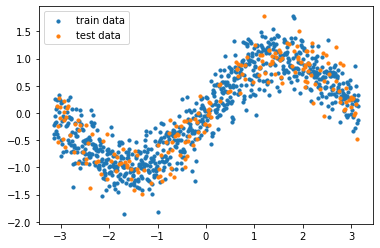

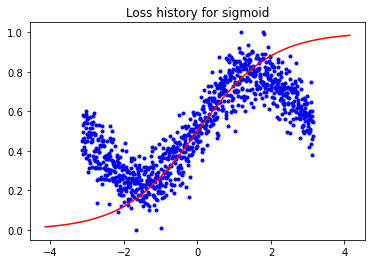

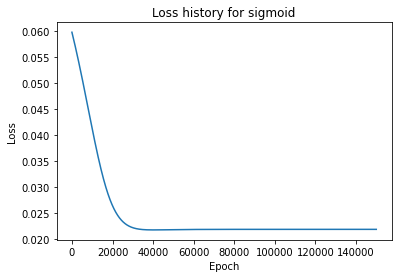

In [40]:
from sklearn.model_selection import train_test_split
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_plot(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


# regression model using sigmoid basic function
def logistic_regression(x, y, epochs, alpha, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    w = np.random.randn(x.shape[1], 1)
    epoch = 1
    loss_history = []
    while True:
        y_hat = sigmoid(np.dot(x_train, w))  # Xw ==> X@w
        error = y_hat - y_train
        loss = (1.0 / x_train.shape[0]) * error.T @ error  # MSE(loss) => 1/(n)*(y_hat-y).T@(y_hat-y)
        loss_history.append(loss[0][0])
        w -= 2 * alpha * x_train.T @ error  # w -= alpha*X.T(Xw-y)
        if epoch % 10000 == 0:
            print(f'Epoch [{epoch}/{epochs}]: loss = {loss}')
        if epoch > epochs or loss_history[-1] < 1e-6:
            break
        epoch += 1
    return w, loss_history

w_sigmoid, loss_history_for_sigmoid = logistic_regression(all_Xs, y_std, 150000, 0.0000001)

# plots
plt.scatter(x_train, y_train, s=10, label='train data')
plt.scatter(x_test, y_test, s=10, label='test data')
plt.legend()
plt.show()

xx = np.linspace(all_Xs.min() - 1, all_Xs.max() + 1, 100).reshape(-1, 1)

xx_sig = sigmoid_plot(xx)
# reshape xx_sig to w_sigmoid.shape
xx_sig = np.array(xx_sig).reshape(xx.shape)
yy = np.dot(xx_sig, w_sigmoid)
plt.scatter(all_Xs, y_std, color='blue', marker=".")
plt.plot(xx, xx_sig, color='red')
plt.title('Loss history for sigmoid')
plt.show()

# plot the loss history
plt.plot(loss_history_for_sigmoid)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history for sigmoid')
plt.show()


In [20]:
# import module
from tabulate import tabulate

# assign data
mydata = [
    ["linear(poly deg 1)", sum(loss_history_for_poly1) / 5],
    ["polynomial degree 2", sum(loss_history_for_poly2) / 5],
    ["polynomial degree 3", sum(loss_history_for_poly3) / 5],
    ["sigmoid", sum(loss_history_for_sigmoid) / 5]
]

# create header
head = ["Model", "Average errors"]

# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+---------------------+------------------+
| Model               |   Average errors |
+=====================+==================+
| linear(poly deg 1)  |          2.068   |
+---------------------+------------------+
| polynomial degree 2 |          1.56867 |
+---------------------+------------------+
| polynomial degree 3 |         10.5968  |
+---------------------+------------------+
| sigmoid             |        679.482   |
+---------------------+------------------+


In [21]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin.fit(all_Xs, all_Ys)

LinearRegression()

In [23]:
# def linear_regression():
#     plt.scatter(x, y, color="grey", marker=".")
#     plt.plot(x, lin.predict(x), color="red")
#     plt.title("Linear Regression")
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.show()
#     return
#
# linear_regression()

In [24]:
# from sklearn.preprocessing import PolynomialFeatures
#
# poly_reg = PolynomialFeatures(degree=2)
# X_poly = poly_reg.fit_transform(x)
# pol_reg = LinearRegression()
# pol_reg.fit(X_poly, y)

In [25]:
# def viz_polymonial():
#     plt.scatter(x, y, color='cyan', marker=".")
#     plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='red')
#     plt.title('Polynomial Regression Degree 2')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show()
#     return
#
#
# viz_polymonial()

In [26]:
# from sklearn.preprocessing import PolynomialFeatures
#
# poly_reg = PolynomialFeatures(degree=3)
# X_poly = poly_reg.fit_transform(x)
# pol_reg = LinearRegression()
# pol_reg.fit(X_poly, y)

In [27]:
# def viz_polymonial():
#     plt.scatter(x, y, color='cyan', marker=".")
#     plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='red')
#     plt.title('Polynomial Regression Degree 3')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.show()
#     return
#
#
# viz_polymonial()